In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import os

from PIL import Image
from skimage import io, color, img_as_float, img_as_ubyte
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

!pip install torchinfo
from torchinfo import summary

!nvidia-smi

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
Fri Jan 13 11:13:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.34       Driver Version: 430.34       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 24%   29C    P8     3W / 250W |   6139MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 24%   33C    P8     6W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+---

In [ ]:
!python --version

root_path = "/media/kondo/Ext4_for_Colab/tomizawa/paper/" #@param {type:"string"}
#@markdown  - Assign a path for your root directory. This root directory should include an image dataset directory ("/data/data_original/") and "/utils/" directory.
#@markdown  - The image dataset is available at a database (URL in #README on the GitHub).
#@markdown  - The library "utils" is available at the same GitHub page with this jupyter notebook.

%cd $root_path 
!pwd
!ls

Python 3.6.10 :: Anaconda, Inc.
/media/kondo/Ext4_for_Colab/tomizawa/paper
/media/kondo/Ext4_for_Colab/tomizawa/paper
data  data_old1  figures  results  results_old	results_test  utils


In [ ]:
from utils.loaders import Args, ImageTransform, MarchantiaDataset, indices_to_loader#, get_data, 
from utils.misc import get_unnormalize, get_datetime, makedirs, set_requires_grad_toFalse, train_model_pytorch_tutorial, compute_loss
from utils.misc import visualize_batch, plot_learning_trajectory, plot_learning_trajectory_semilogy, save_model_results, save_data_indices

In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [ ]:
class MarchantiaDataset(data.Dataset):
    def __init__(self, dataset, transform=None, randomLabels=None):
        self.dataset = dataset
        self.transform = transform
        self.randomLabels = randomLabels
        print(type(randomLabels))

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0]) #img
        else:
            x = self.dataset[index][0]
        
        if type(self.randomLabels).__module__ == "numpy":
            y = self.randomLabels[index] #random label
            # y = torch.randint(0, 2, (1,)).item() #random label
        else:
            y = self.dataset[index][1] #label

        return x, y

        
def get_data(args, full_dataset, Transform, MarchantiaDataset, seed=None, label_randomize=False):
    targets = np.array(full_dataset.targets)
    print(targets)

    if label_randomize:
        randomLabels = targets.copy()
        rng = np.random.default_rng(seed)
        rng.shuffle(randomLabels)
    else:
        randomLabels = None
    print('shuffled targets : ', randomLabels)
    dataset_noaug = MarchantiaDataset(full_dataset, Transform.data_transform["valid"], randomLabels)
    dataset_aug = MarchantiaDataset(full_dataset, Transform.data_transform["train"], randomLabels)

    train_indices, test_indices = train_test_split(np.arange(targets.shape[0]), test_size=0.2, stratify=targets, random_state=seed)
    train_indices, val_indices = train_test_split(train_indices, test_size=0.2, stratify=targets[train_indices], random_state=seed)

    train_dataset = data.Subset(dataset_aug, indices=train_indices)
    val_dataset = data.Subset(dataset_noaug, indices=val_indices)
    test_dataset = data.Subset(dataset_noaug, indices=test_indices)

    train_loader = data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)
    test_loader = data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    dataset_attributes = {'n_train': len(train_dataset), 'n_val': len(val_dataset), 'n_test': len(test_dataset)}
    dataset_indices = {'targets': targets,
                       'idx_train': train_indices, 'idx_val': val_indices, 'idx_test': test_indices}
                          
    return train_loader, val_loader, test_loader, dataset_attributes, dataset_indices


def visualize_batch(images, labels, ncols=4):
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(3*ncols, 3))
    for n in range(ncols):
        img = images[n].cpu().numpy()
        img = img.transpose((1, 2, 0))
        ax[n].imshow(img)
        ax[n].set_title(labels[n])
        ax[n].axis('off')

{'size_image': 224, 'batch_size': 32, 'root': './data/data_original/Aus/0d'}
Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./data/data_original/Aus/0d
{'Aus_0d_F': 0, 'Aus_0d_M': 1}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

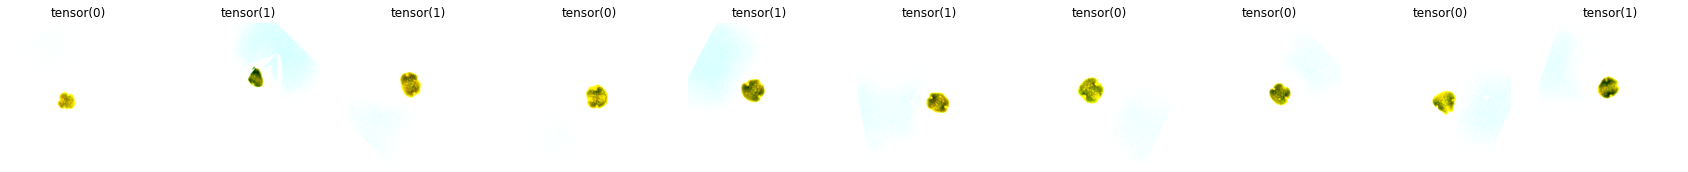

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0025,  0.0134, -0.0117,  ...,  0.0072,  0.0079,  0.0004],
        [-0.0024, -0.0014,  0.0172,  ...,  0.0088, -0.0128,  0.0204]],
       requires_grad=True), Parameter containing:
tensor([-0.0176,  0.0103], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7692 Acc: 0.5078
val Loss: 0.8329 Acc: 0.5625

Epoch 10/499
----------
train Loss: 0.6974 Acc: 0.4922
val Loss: 0.7355 Acc: 0.5625

Epoch 20/499
----------
train Loss: 0.6587 Acc: 0.6094
val Loss: 0.7713 Acc: 0.5000

Epoch 30/499
----------
train Loss: 0.6575 Acc: 0.5938
val Loss: 0.7754 Acc: 0.5938

Epoch 40/499
----------
train Loss: 0.6481 Acc: 0.6406
val Loss: 0.8223 Acc: 0.5312

Epoch 50/499
----------
train Loss: 0.6431 Acc: 0.5703
val Loss: 0.8069 Acc: 0.5312

Epoch 60/499
----------
train Loss: 0.5956 Acc: 0.6953
val Loss: 0.8076 Acc: 0.5000

Epoch 70/499
----------
train Loss: 0.5691 Acc: 0.7188
val Loss: 0.8094 Acc: 0.5938

Epoch 80/499
----------
train Loss: 0.65

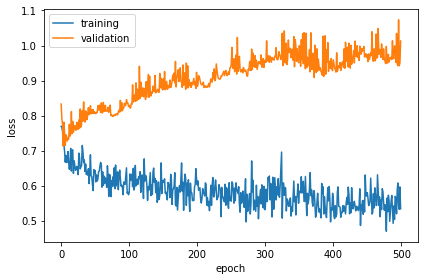

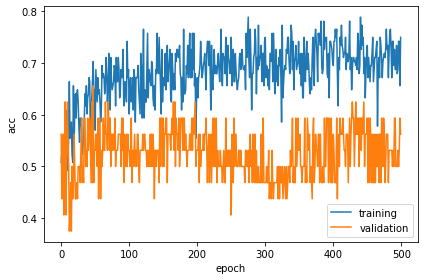

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
shuffled targets :  [1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1
 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1
 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1
 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1
 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 0
 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
{'n_train': 128, 'n_val': 32, 'n_test': 40}
40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

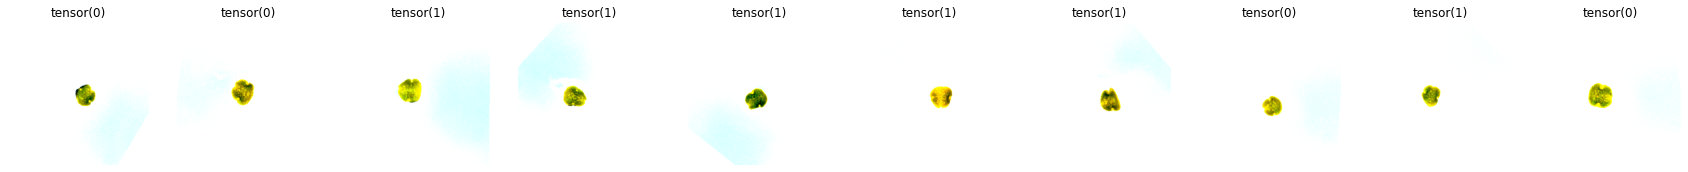

['weight', 'bias']
[Parameter containing:
tensor([[-0.0076,  0.0196,  0.0208,  ..., -0.0123,  0.0118,  0.0014],
        [-0.0056,  0.0050, -0.0204,  ..., -0.0150, -0.0156,  0.0052]],
       requires_grad=True), Parameter containing:
tensor([-0.0062,  0.0041], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7616 Acc: 0.4766
val Loss: 0.6155 Acc: 0.6875

Epoch 10/499
----------
train Loss: 0.6692 Acc: 0.5781
val Loss: 0.6864 Acc: 0.5938

Epoch 20/499
----------
train Loss: 0.6684 Acc: 0.5703
val Loss: 0.7434 Acc: 0.3750

Epoch 30/499
----------
train Loss: 0.6284 Acc: 0.6406
val Loss: 0.7372 Acc: 0.3750

Epoch 40/499
----------
train Loss: 0.6133 Acc: 0.6562
val Loss: 0.7468 Acc: 0.3750

Epoch 50/499
----------
train Loss: 0.6035 Acc: 0.6641
val Loss: 0.7196 Acc: 0.4688

Epoch 60/499
----------
train Loss: 0.6003 Acc: 0.6953
val Loss: 0.8979 Acc: 0.2812

Epoch 70/499
----------
train Loss: 0.6062 Acc: 0.6094
val Loss: 0.7549 Acc: 0.3750

Epoch 80/499
----------
train Loss: 0.58

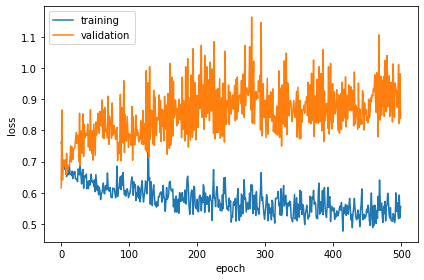

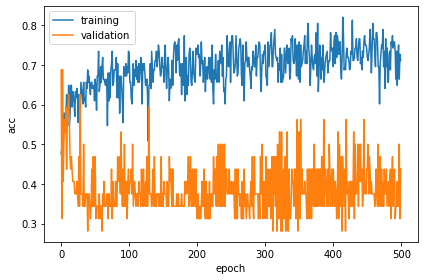

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
shuffled targets :  [1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1
 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0
 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0
 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 0
 0 1 0 0 1 1 0 0 1 0 1 0 1 0 0]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
{'n_train': 128, 'n_val': 32, 'n_test': 40}
40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

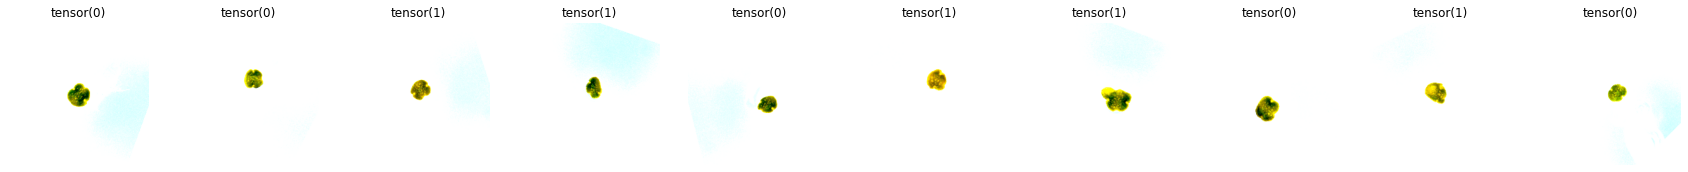

['weight', 'bias']
[Parameter containing:
tensor([[-0.0040, -0.0132,  0.0109,  ..., -0.0212,  0.0029, -0.0067],
        [-0.0126, -0.0105,  0.0084,  ..., -0.0045, -0.0092,  0.0174]],
       requires_grad=True), Parameter containing:
tensor([-0.0218,  0.0045], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7345 Acc: 0.5781
val Loss: 0.7827 Acc: 0.4688

Epoch 10/499
----------
train Loss: 0.6622 Acc: 0.6094
val Loss: 0.7568 Acc: 0.4375

Epoch 20/499
----------
train Loss: 0.6606 Acc: 0.6016
val Loss: 0.8158 Acc: 0.4062

Epoch 30/499
----------
train Loss: 0.6178 Acc: 0.6797
val Loss: 0.7964 Acc: 0.4062

Epoch 40/499
----------
train Loss: 0.6470 Acc: 0.6250
val Loss: 0.8258 Acc: 0.4062

Epoch 50/499
----------
train Loss: 0.5933 Acc: 0.6719
val Loss: 0.8255 Acc: 0.4062

Epoch 60/499
----------
train Loss: 0.5768 Acc: 0.7109
val Loss: 0.8183 Acc: 0.5312

Epoch 70/499
----------
train Loss: 0.5576 Acc: 0.7344
val Loss: 0.8329 Acc: 0.4062

Epoch 80/499
----------
train Loss: 0.55

In [ ]:
strains = ['Aus', 'RIL5', 'Tak']
days = ['0d', '1d', '2d', '3d', '4d', '7d']
ablations = ['original_noScaleBar']
multilabel = False
label_randomize = True
results_dname = 'results_randomLabel_forGitHub'

args = Args()
for ablation in ablations:
  for strain in strains:
    for day in days:
      args.root = './data/data_' + ablation + '/' + strain + '/' + day
      print(args.__dict__)

      Transform = ImageTransform(fill=255)
      full_dataset = ImageFolder(root=args.root)
      print(full_dataset)
      print(full_dataset.class_to_idx)
      print(full_dataset.targets)

      for n_loop in range(5):
        seed = n_loop + 1000000000
        train_loader, val_loader, test_loader, dataset_attributes, dataset_indices = get_data(args, full_dataset, Transform, MarchantiaDataset, seed=seed, label_randomize=label_randomize)
        print(dataset_attributes)
        print(len(test_loader.dataset))

        targets, train_indices, val_indices, test_indices = dataset_indices['targets'], dataset_indices['idx_train'], dataset_indices['idx_val'], dataset_indices['idx_test']
        dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

        train_images, labels = next(iter(train_loader))
        visualize_batch(train_images, labels, ncols=10); plt.show()

        model = resnet50(pretrained=True)
        set_requires_grad_toFalse(model) ## requires_grad=False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2) ## requires_grad=True only in overwritten paramters
        print([name for name, _ in model.fc.named_parameters()])
        print([param for param in model.fc.parameters()])
        model.to(dev)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
        model, train_losses, train_accs, val_losses, val_accs = train_model_pytorch_tutorial(model, dataloaders, dev, criterion, optimizer, num_epochs=500, multilabel=multilabel)
        print(np.argmax(val_accs))
        _, val_acc = compute_loss(model, val_loader, dev, multilabel=multilabel)
        print('val_acc: ', val_acc)
        test_loss, test_acc = compute_loss(model, test_loader, dev)
        print('test acc', test_acc)

        ## save
        dt_now = get_datetime()
        print(args.root.split('/')[-2] + args.root.split('/')[-1])
        strain_day = args.root.split('/')[-2] + '_' + args.root.split('/')[-1]
        results_path = results_dname + '/' + dt_now + '_' + strain_day + '_' + ablation + '/'
        makedirs(results_path)

        ## .txt to save seed & epoch with max validation accuracy
        f = open(results_path + 'model_stats.txt', 'w')
        f.write('seed : ' + str(seed) + '\n')
        f.write('epoch with max val. acc. : ' + str(np.argmax(val_accs)) + '\n')
        f.close()

        figtype = 'learning_trajectory_'
        plot_learning_trajectory(train_losses, val_losses); plt.savefig(results_path + figtype + 'loss.png'); plt.show()
        plot_learning_trajectory(train_accs, val_accs, ylabel='acc'); plt.savefig(results_path + figtype + 'acc.png'); plt.show()

        save_model_results(results_path, dt_now, model, train_losses, train_accs, val_losses, val_accs, test_loss, test_acc)
        save_data_indices(results_path, train_indices, val_indices, test_indices)